In [16]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from HMC import HMC
from diagnostic import geweke, gelman_rubin
from pathlib import Path

tf.random.set_seed(1234)

# Pre-training and setup
## Creating a dummy model

Our model is a basic 4x1 Dense layer, without activation and with $L_1$ regularization. It uses the MSE loss. I added a normalization layer for increased numerical stability.

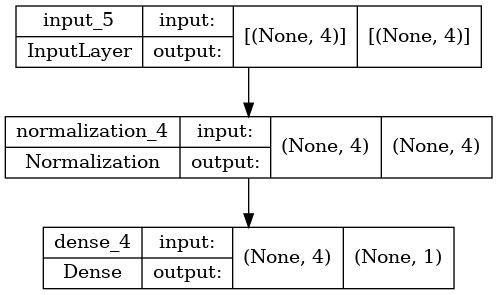

In [17]:
model = keras.Sequential([
    keras.Input(shape=(4,)),
    keras.layers.Normalization(),
    keras.layers.Dense(1, use_bias=True) #, kernel_regularizer=tf.keras.regularizers.l1(0.1))
])
model.compile(optimizer=keras.optimizers.Adam(1e-2), loss=keras.losses.MeanSquaredError())
keras.utils.plot_model(model, show_shapes=True, to_file="../etc/test.png")

## Data

We create a trivial training set, with a regular grid $t$ sampled on $[-\pi, \pi]$. We set
- $x = (t^2, t, \cos(t), - t^3)$
- $y = t$
Thus we expect our model to only use the 2nd coordinate of $x$ for its prediction. When accounted for the normalization layer, the final parameters should be $(0,1.85,0,0)$.

In [18]:
# creating fake data
batch_size=1000
t = np.linspace(-3.14, 3.14, batch_size, dtype=np.float32)
x = np.stack([
    t ** 2,
    t,
    np.cos(t),
    - t ** 3
]).T
y = np.expand_dims(t, axis=1)  + 0 * np.random.randn(batch_size, 1)

## Model training

In [19]:
# model pre-training
model.layers[0].adapt(x)
model.fit(x, y, epochs=500, verbose=0)

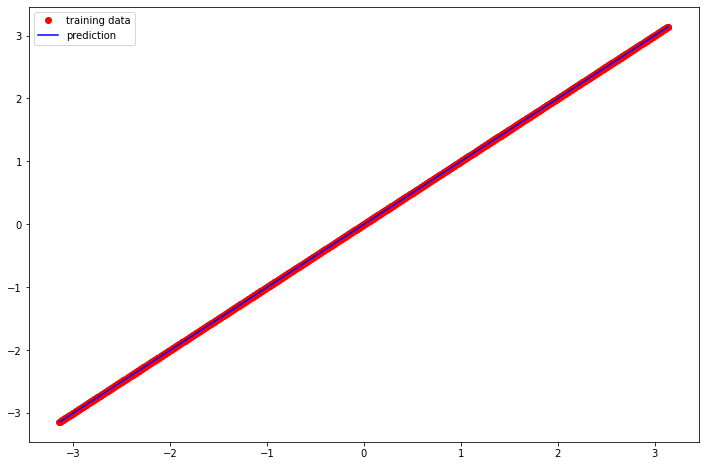

[<tf.Variable 'dense_4/kernel:0' shape=(4, 1) dtype=float32, numpy=
 array([[ 1.1481393e-06],
        [ 1.8146925e+00],
        [-7.7109075e-07],
        [-4.2956941e-07]], dtype=float32)>,
 <tf.Variable 'dense_4/bias:0' shape=(1,) dtype=float32, numpy=array([2.8322142e-06], dtype=float32)>]

In [20]:
# plot fitted prediction and model pre-trained parameters
fig = plt.figure(figsize=(12,8))
plt.plot(t, y, 'ro', label="training data")
plt.plot(t, model(x), 'b-', label="prediction")
plt.legend()
plt.show()
model.trainable_variables

After 500 training step, we have a decent fit. Our parameters aren't set to $(0,1.85,0,0)$, but it should be good enough as a pre-training.

# HMC
## HMC walk

We now use the new `HMC` super-model to train our model, and predict uncertainties. It runs in about 20 seconds on my setup (GTX 1660 Ti).

In [21]:
burn_in = 2000
n_iter = 2000

def sample(model):
    # Create HMC super-model
    hmc = HMC(model, L=15, epsilon_min=7e-3, epsilon_max=7e-3 , batch_size=batch_size, n_obs=batch_size)

    # Initialize bookkeeping
    parameters = []  # bookkeeping the parameters
    log_gamma = []  # bookkeeping the loggamma
    log_lambda = []  # bookkeeping the loggamma
    log_likelihood = []  # bookkeeping the loggamma
    hamiltonians = []
    acceptance = []
    inputs = (tf.convert_to_tensor(x, dtype=tf.float32), tf.convert_to_tensor(y, dtype=tf.float32))

    # training loop
    hmc.init_parameters(inputs)
    for step in tqdm(range(n_iter + burn_in)):
        new_state, loss, p, accepted, h = hmc(inputs, tf.constant(step, dtype=tf.float32), tf.constant(n_iter, dtype=tf.float32))

        # bookkeeping
        if step > burn_in:
            parameters.append(new_state.position)
            log_gamma.append(new_state.log_gamma)
            log_lambda.append(new_state.log_lambda)
            log_likelihood.append(loss)
            acceptance.append(accepted)
            hamiltonians.append(h)

    parameters = tf.stack(parameters, axis=0).numpy()
    log_gamma = tf.concat(log_gamma, axis=0).numpy()
    log_lambda = tf.concat(log_lambda, axis=0).numpy()
    log_likelihood = tf.concat(log_likelihood, axis=0).numpy()
    hamiltonians = tf.concat(hamiltonians, axis=0).numpy()
    acceptance = np.array(acceptance)
    print(f"Sampling done: {n_iter} steps with accepting rate {np.mean(acceptance)}")
    return hmc, parameters, log_gamma, log_lambda, log_likelihood, hamiltonians, acceptance

In [22]:
hmc, parameters, log_gamma, log_lambda, log_likelihood, hamiltonians, acceptance = sample(model)

100%|██████████| 4000/4000 [00:23<00:00, 172.61it/s]


Sampling done: 2000 steps with accepting rate 0.36568284142071034


## HMC estimates and uncertainties

We compute these estimates the same way it was done in previous works

In [23]:
# Computing MAP estimate
idx_MAP = np.argmin(log_likelihood)
MAP = parameters[idx_MAP, :]
hmc.set_model_params(MAP)
y_MAP = hmc.model(x)

# preparing sampling
precision = np.exp(log_gamma)
num_dim = 1
n_samples = 1000
trajectories = np.zeros((batch_size, num_dim, n_samples))
sigma_normal = np.std(y)

# sampling
for k in tqdm(range(n_samples)):
    idx_1 = np.random.randint(0, n_iter - 1)
    idx_2 = np.random.randint(0, n_iter - 1)
    w_sample = parameters[-idx_1, :]
    precision_here = precision[-idx_2] * num_dim
    hmc.set_model_params(w_sample)
    trajectories[:, :, k] = hmc.model(x) + sigma_normal * np.random.normal() / np.sqrt(precision_here)

mu_pred = np.mean(trajectories, axis=2)
sigma_pred = np.var(trajectories, axis=2)

100%|██████████| 1000/1000 [00:01<00:00, 612.47it/s]


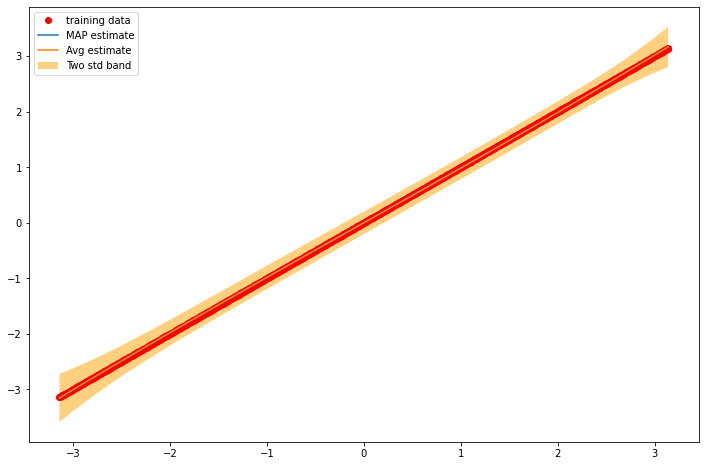

[ 0.0026941   1.7837651   0.00274434 -0.02744675 -0.07680999]


In [24]:
# plot results and display MAP parameters
plt.figure(figsize=(12, 8))
plt.plot(t, y, 'ro', label="training data")
plt.plot(t, y_MAP, label="MAP estimate")
plt.plot(t, mu_pred, label="Avg estimate")
lower = mu_pred[:, 0] - 2 * np.sqrt(sigma_pred[:, 0])
upper = mu_pred[:, 0] + 2 * np.sqrt(sigma_pred[:, 0])
plt.fill_between(t, lower, upper, facecolor="orange", alpha=0.5, label="Two std band")
plt.legend()
plt.show()
print(MAP)

This result shows some uncertainty despite the simplicity of the model. However, the MAP estimate is very close from the optimal value.

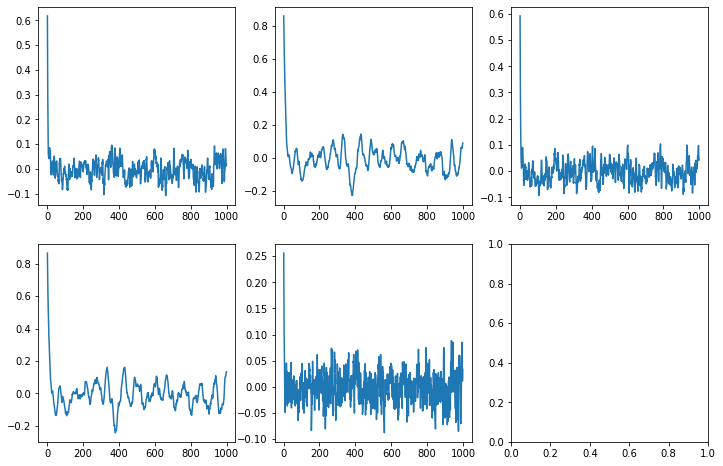

In [25]:
# plot auto-correlation

fig, axs = plt.subplots(2,3, figsize=(12,8))
axs = axs.flatten()
max_lag = 1000
for i in range(parameters.shape[1]):
    auto_cor = []
    mean = np.mean(parameters[:,i])
    var = np.var(parameters[:,i])
    for lag in range(1,max_lag):
        param = parameters[lag:, i]
        param_lagged = parameters[:-lag, i]
        auto_cor.append(np.mean((param-mean) * (param_lagged-mean))/var)
    axs[i].plot(np.arange(1,max_lag), auto_cor)
plt.show()

The auto-correlation plots for the 4 parameters show very good result.

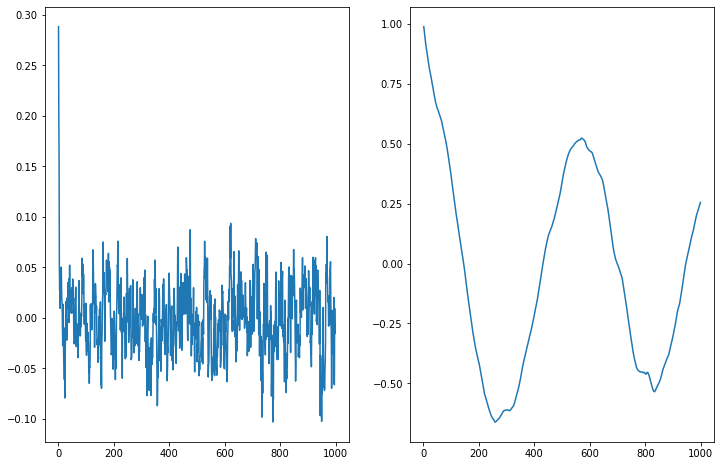

In [26]:
fig, axs = plt.subplots(1,2, figsize=(12,8))
axs = axs.flatten()

mean = np.mean(log_gamma)
var = np.var(log_gamma)
auto_cor = []
for lag in range(1,max_lag):
    param = log_gamma[lag:]
    param_lagged = log_gamma[:-lag]
    auto_cor.append(np.mean((param-mean) * (param_lagged-mean))/var)
axs[0].plot(np.arange(1,max_lag), auto_cor)

mean = np.mean(log_lambda)
var = np.var(log_lambda)
auto_cor = []
for lag in range(1,max_lag):
    param = log_lambda[lag:]
    param_lagged = log_lambda[:-lag]
    auto_cor.append(np.mean((param-mean) * (param_lagged-mean))/var)
axs[1].plot(np.arange(1,max_lag), auto_cor)
plt.show()

The results are also quite good for $\log(\gamma)$ and $\log(\lambda)$.

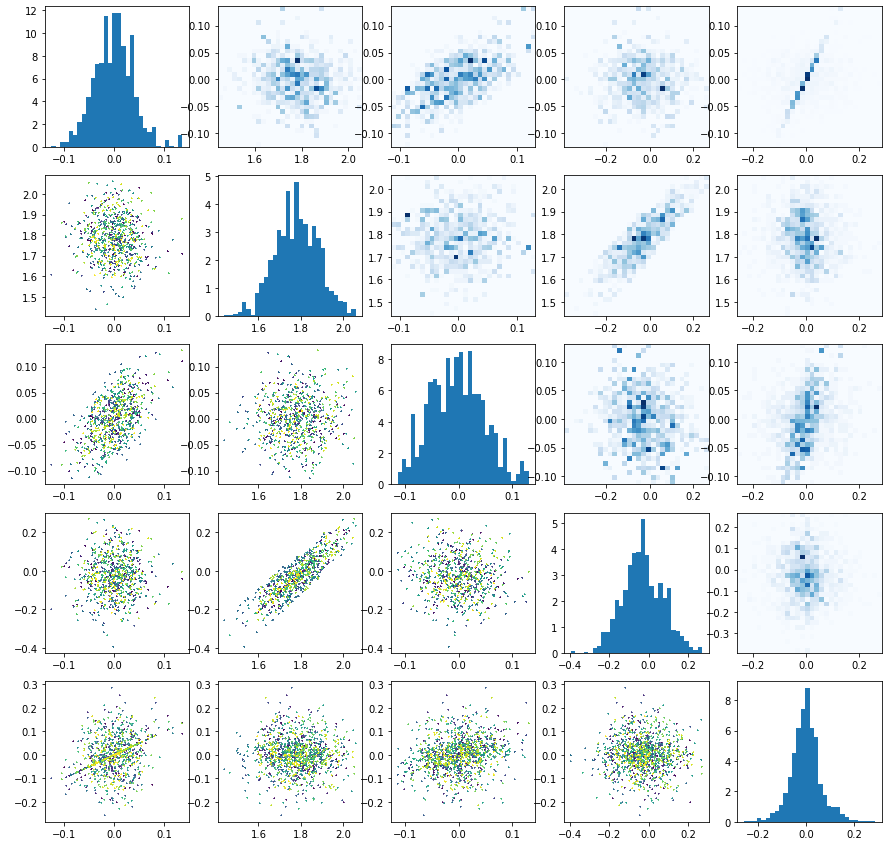

In [33]:
# plot parameters spread
fig, axs = plt.subplots(5, 5, figsize=(15, 15))
for i in range(5):
    axs[i, i].hist(parameters[:, i], bins=30, density=True)
    for j in range(i):
        axs[i, j].scatter(parameters[:, j], parameters[:, i], s=1, marker="+", c=np.arange(parameters.shape[0]))
    for j in range(i + 1, 5):
        axs[i, j].hist2d(parameters[:, j], parameters[:, i], bins=30, cmap="Blues")
plt.show()


The parameters seem to be spread according to gaussian distributions, which is expected. Also, there is a high correlation between $t$ and $-t^3$ coefficients, and between $t^2$ and $\cos(t)$, which is expected. But they seem a bit too widely spread.

In [28]:
# Diagnostic: Geweke z-score
print("Home-made Geweke test for log(γ): ", geweke(log_gamma)[0])
print("Home-made Geweke test for log(λ): ", geweke(log_lambda)[0])
print("Home-made Geweke test for parameters: ", geweke(parameters)[0])


Home-made Geweke test for log(γ):  -0.03502105
Home-made Geweke test for log(λ):  -0.33824235
Home-made Geweke test for parameters:  [ 0.21747053 -0.15031259  0.1608836  -0.12599035  0.11788685]


The Geweke z-score is decent for all parameters. An official implementation should be used though, as the current one doesn't use spectral estimates of the variance.

In [29]:
tf.random.set_seed(0)
model = keras.Sequential([keras.Input(shape=(4,)), keras.layers.Normalization(), keras.layers.Dense(1, use_bias=True)])
model.compile(optimizer=keras.optimizers.Adam(1e-2), loss=keras.losses.MeanSquaredError())
model.layers[0].adapt(x)
model.fit(x, y, epochs=500, verbose=0)
_, parameters1, log_gamma1, log_lambda1, log_likelihood1, hamiltonians1, acceptance1 = sample(model)

tf.random.set_seed(1)
model = keras.Sequential([keras.Input(shape=(4,)), keras.layers.Normalization(), keras.layers.Dense(1, use_bias=True)])
model.compile(optimizer=keras.optimizers.Adam(1e-2), loss=keras.losses.MeanSquaredError())
model.layers[0].adapt(x)
model.fit(x, y, epochs=500, verbose=0)
_, parameters2, log_gamma2, log_lambda2, log_likelihood2, hamiltonians2, acceptance2 = sample(model)

tf.random.set_seed(2)
model = keras.Sequential([keras.Input(shape=(4,)), keras.layers.Normalization(), keras.layers.Dense(1, use_bias=True)])
model.compile(optimizer=keras.optimizers.Adam(1e-2), loss=keras.losses.MeanSquaredError())
model.layers[0].adapt(x)
model.fit(x, y, epochs=500, verbose=0)
_, parameters3, log_gamma3, log_lambda3, log_likelihood3, hamiltonians3, acceptance3 = sample(model)

100%|██████████| 4000/4000 [00:23<00:00, 173.44it/s]


Sampling done: 2000 steps with accepting rate 0.327663831915958


100%|██████████| 4000/4000 [00:22<00:00, 174.12it/s]


Sampling done: 2000 steps with accepting rate 0.32716358179089544


100%|██████████| 4000/4000 [00:23<00:00, 173.73it/s]


Sampling done: 2000 steps with accepting rate 0.3281640820410205


In [30]:
dir = Path("../etc/diagnostic")
dir.mkdir(exist_ok=True)

np.save(dir / "log_gamma.npy", np.stack([log_gamma, log_gamma1, log_gamma2, log_gamma3], axis=1).astype(np.float64))
np.save(dir / "log_lambda.npy", np.stack([log_lambda, log_lambda1, log_lambda2, log_lambda3], axis=1).astype(np.float64))
tmp = np.stack([parameters, parameters1, parameters2, parameters3], axis=2).astype(np.float64)
for i in range(tmp.shape[1]):
    np.save(dir / ("parameter" + str(i) + ".npy"), tmp[:,i,:])

In [31]:
print("Gelman-Rubin test for log(γ): ", gelman_rubin(np.stack([log_gamma, log_gamma1, log_gamma2, log_gamma3], axis=1)))
print("Gelman-Rubin test for log(λ): ", gelman_rubin(np.stack([log_lambda, log_lambda1, log_lambda2, log_lambda3], axis=1)))
print("Gelman-Rubin test for parameters: ", gelman_rubin(np.stack([parameters, parameters1, parameters2, parameters3], axis=2)))

Gelman-Rubin test for log(γ):  1.000232756366011
Gelman-Rubin test for log(λ):  1.0494160239251629
Gelman-Rubin test for parameters:  [1.0012552 1.0009013 1.0014752 1.0008503 1.0007561]


This time, the Gelman-Rubin test is very conclusive for all our weights and for $\log(\gamma)$ and $\log(\lambda)$ as well.